In [2]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.series import Series
from scipy.stats import chisquare, chi2, shapiro
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
import sys

sys.path.append("../")

from fast_food_nutrition.algo import NutritionCalculator
from fast_food_nutrition.analysis import ChiSquaredTest, Outliers, TTest, ZTest
from fast_food_nutrition.etl import FastFoodMenuETL
from fast_food_nutrition.model import COLOR, FoodIntakeType, FoodNutritionFeatures, FoodNutritionMapping, Nutrition, Sex, Test
from fast_food_nutrition.viz import FastFoodNutritionVisualizer

In [3]:
etl = FastFoodMenuETL()
menu = etl.load_menu_items()
menu.dtypes 

menu_item        string[python]
calories                float64
fat                     float64
carbohydrates           float64
fiber                   float64
protein                 float64
dtype: object

In [4]:
menu.describe()

,calories,fat,carbohydrates,fiber,protein
count,1117.000000,1117.000000,1117.000000,1117.000000,1117.000000
mean,341.264100,14.354969,61.120859,1.844226,13.001611
std,437.434844,27.606401,69.729333,3.961610,20.081804
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,140.000000,1.000000,24.000000,0.000000,3.000000
50%,270.000000,7.000000,41.000000,1.000000,9.000000
75%,450.000000,21.000000,65.000000,2.000000,18.000000
max,9850.000000,624.000000,616.000000,63.000000,442.000000


In [5]:
len(menu)

1117

### Drop duplicates and remove outliers 

In [6]:
columns = list(menu.columns)[1:]
menu = Outliers.filter_outliers(menu, columns)

In [7]:
menu.set_index('menu_item', inplace=True)
menu = menu.loc[~menu.index.duplicated(), :]
menu = menu.drop_duplicates(keep='last')

In [8]:
len(menu)

674

In [9]:
menu.describe()

,calories,fat,carbohydrates,fiber,protein
count,674.000000,674.000000,674.000000,674.000000,674.000000
mean,309.023739,13.223294,39.881306,1.354599,11.944807
std,189.894855,12.271499,25.292068,1.397435,10.540781
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,146.250000,2.000000,24.000000,0.000000,3.000000
50%,290.000000,10.000000,38.000000,1.000000,10.000000
75%,450.000000,22.000000,53.000000,2.000000,19.000000
max,900.000000,51.000000,126.000000,5.000000,40.000000


In [10]:
menu

,calories,fat,carbohydrates,fiber,protein
menu_item,,,,,
Strawberry Acai Starbucks Refreshers™ Beverage,80.0,0.0,18.0,1.0,0.0
Very Berry Hibiscus Starbucks Refreshers™ Beverage,60.0,0.0,14.0,1.0,0.0
Evolution Fresh™ Organic Ginger Limeade,110.0,0.0,28.0,0.0,0.0
Iced Espresso Classics - Caffe Mocha,140.0,2.5,23.0,0.0,5.0
Iced Espresso Classics - Caramel Macchiato,130.0,2.5,21.0,0.0,5.0
...,...,...,...,...,...
Crispy Bell Peppers,80.0,6.0,6.0,0.0,1.0
Harvest Nut Granola,70.0,2.0,10.0,0.0,1.0
Seasoned Tortilla Strips,70.0,4.0,8.0,1.0,1.0


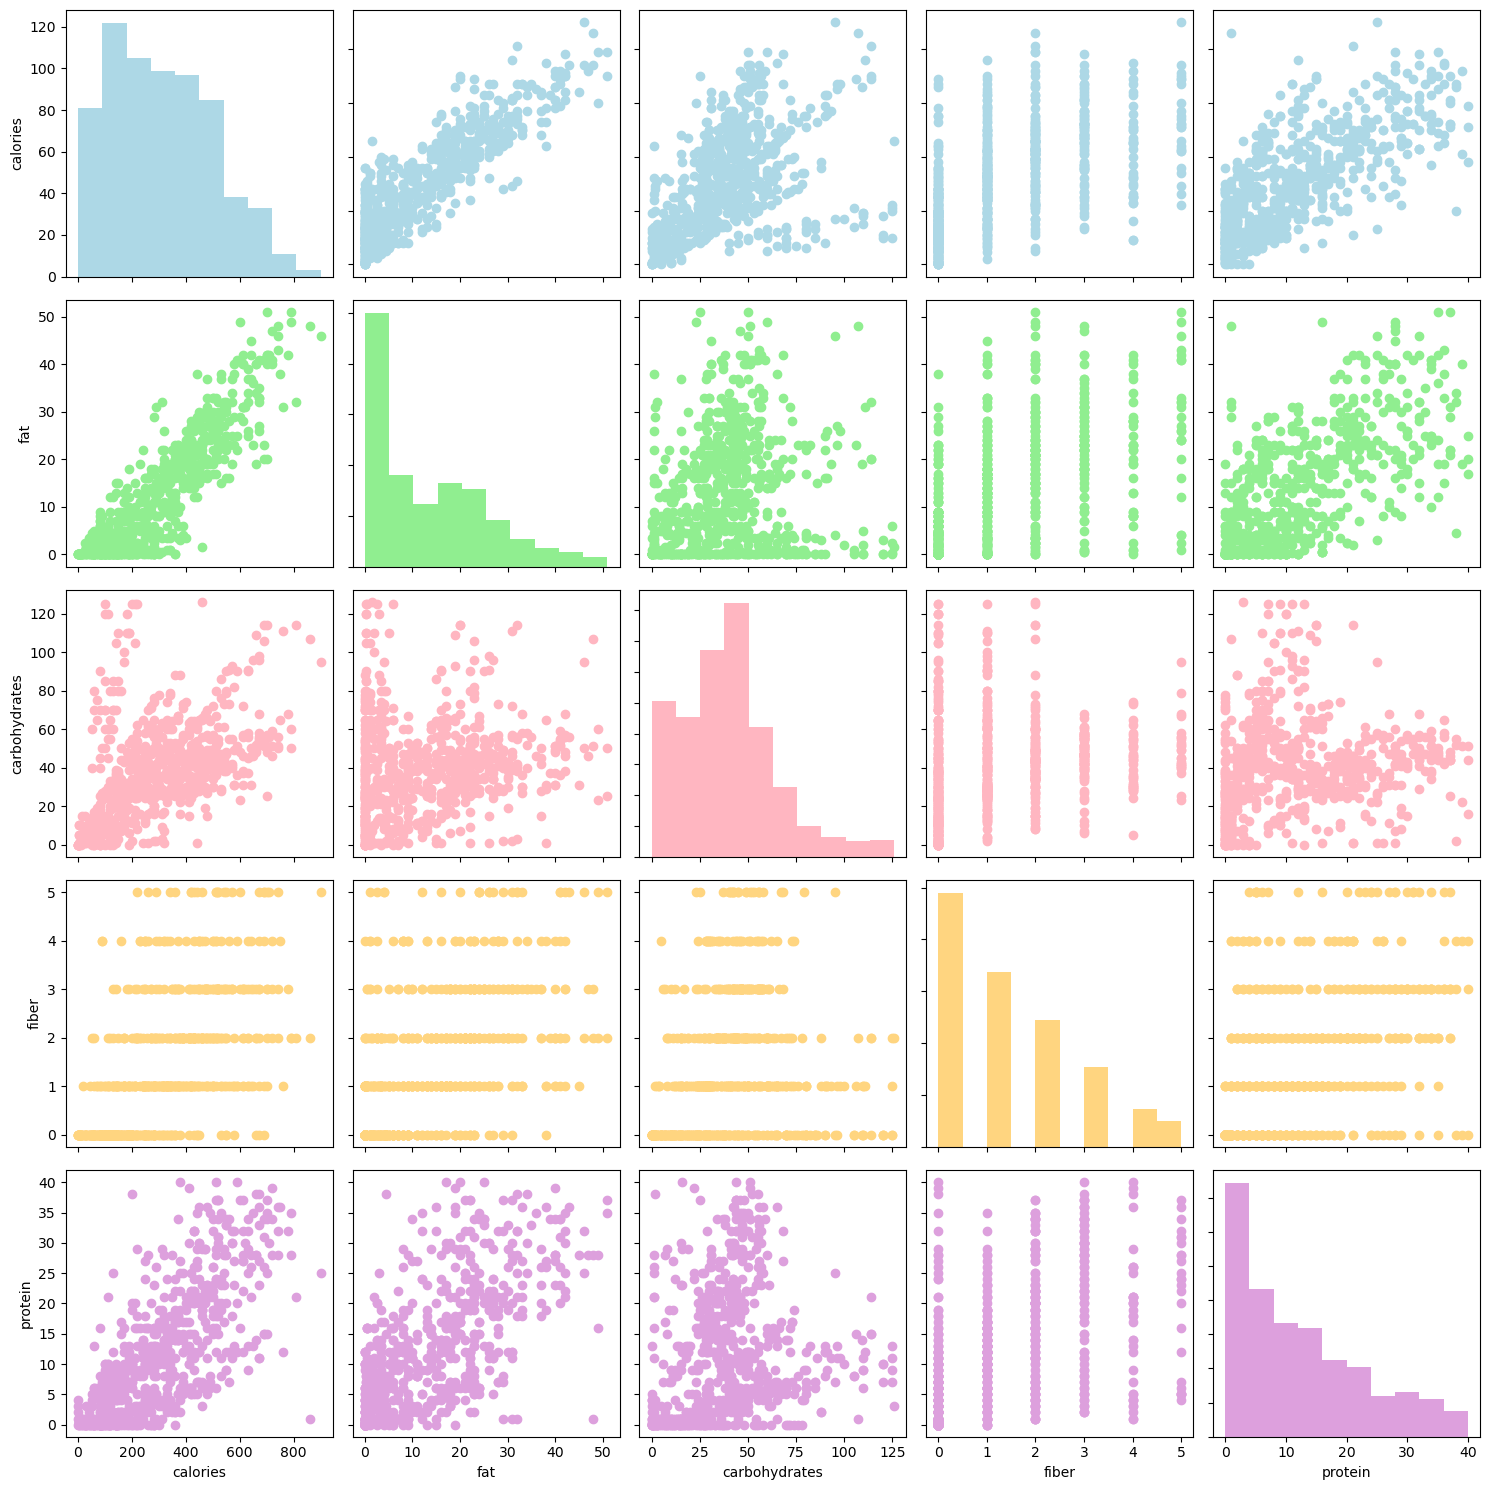

In [11]:
FastFoodNutritionVisualizer.generate_scatter_plots(menu)

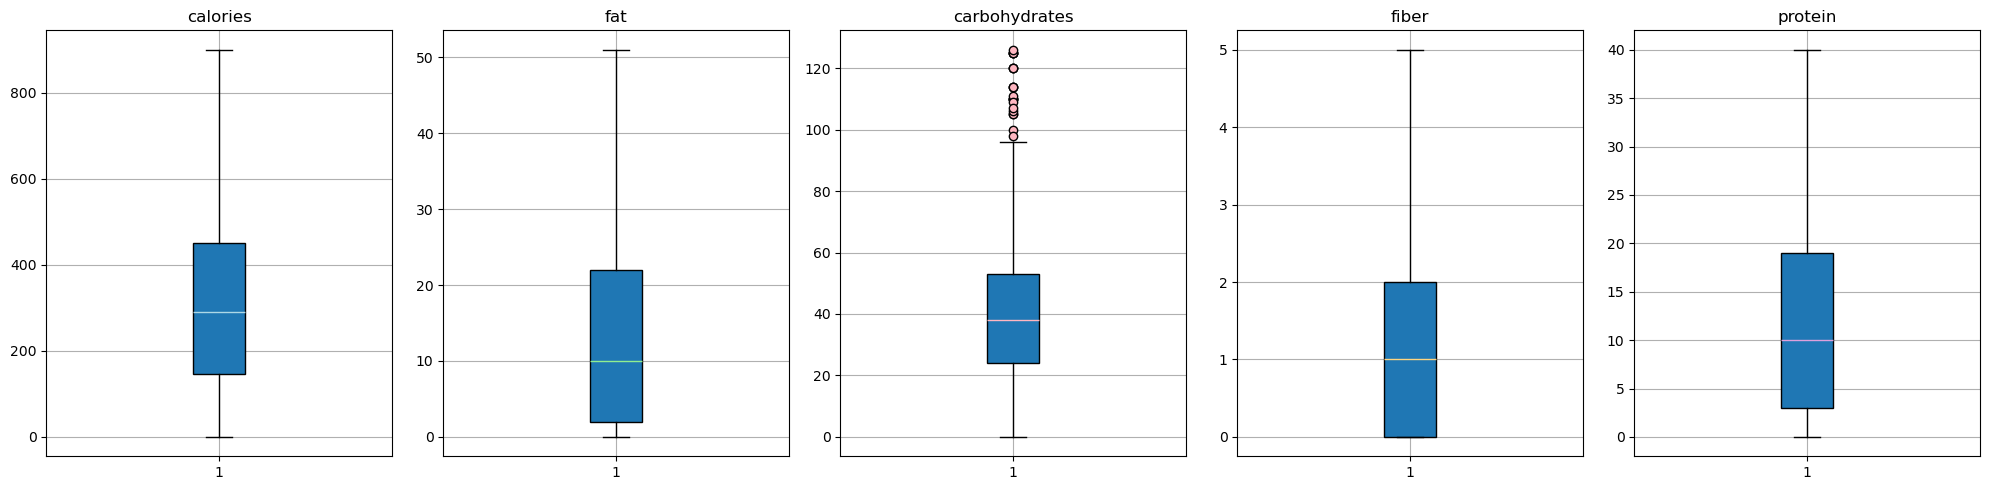

In [12]:
FastFoodNutritionVisualizer.generate_box_plot(menu)

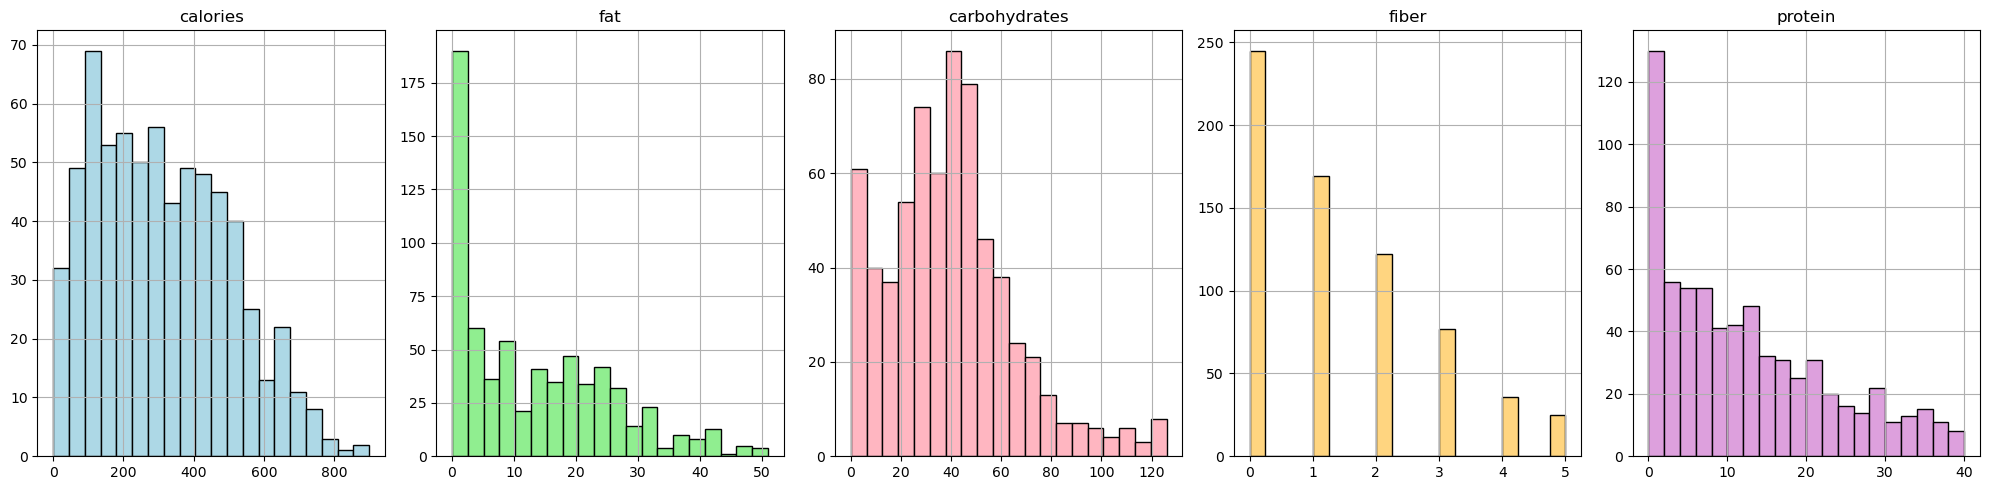

In [13]:
FastFoodNutritionVisualizer.generate_histogram_plots(menu)

In [14]:
scaler = MinMaxScaler()

menu_scaled = pd.DataFrame(scaler.fit_transform(menu), columns=menu.columns, index=menu.index)
menu_scaled

,calories,fat,carbohydrates,fiber,protein
menu_item,,,,,
Strawberry Acai Starbucks Refreshers™ Beverage,0.088889,0.000000,0.142857,0.2,0.000
Very Berry Hibiscus Starbucks Refreshers™ Beverage,0.066667,0.000000,0.111111,0.2,0.000
Evolution Fresh™ Organic Ginger Limeade,0.122222,0.000000,0.222222,0.0,0.000
Iced Espresso Classics - Caffe Mocha,0.155556,0.049020,0.182540,0.0,0.125
Iced Espresso Classics - Caramel Macchiato,0.144444,0.049020,0.166667,0.0,0.125
...,...,...,...,...,...
Crispy Bell Peppers,0.088889,0.117647,0.047619,0.0,0.025
Harvest Nut Granola,0.077778,0.039216,0.079365,0.0,0.025
Seasoned Tortilla Strips,0.077778,0.078431,0.063492,0.2,0.025


In [15]:
menu_scaled.describe()

,calories,fat,carbohydrates,fiber,protein
count,674.000000,674.000000,674.000000,674.000000,674.00000
mean,0.343360,0.259280,0.316518,0.270920,0.29862
std,0.210994,0.240618,0.200731,0.279487,0.26352
min,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.162500,0.039216,0.190476,0.000000,0.07500
50%,0.322222,0.196078,0.301587,0.200000,0.25000
75%,0.500000,0.431373,0.420635,0.400000,0.47500
max,1.000000,1.000000,1.000000,1.000000,1.00000


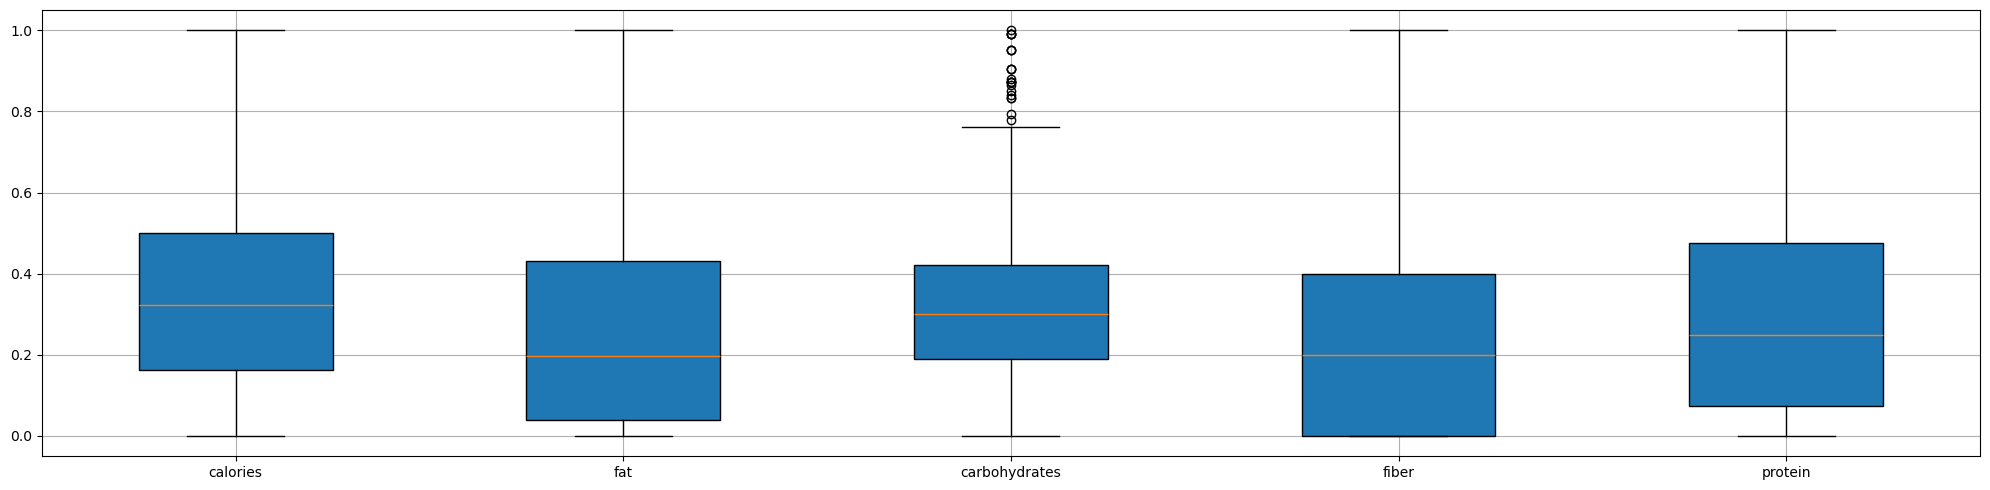

In [16]:
FastFoodNutritionVisualizer.generate_box_plot(menu_scaled, merge=True)

### Check for normality in the distribution using te Shapiro-Wilk Test

In [17]:
for column in menu.columns:
    data = list(menu[column])
    test_statistic, p_value = shapiro(data)

    if p_value > 0.05:
        print(f"Data for {column} appears to be normally distributed as the test_statistic is {test_statistic} and the p_value is {p_value}")
        print(f"As a result you cannot use the chi-distribution to estimate the standard deviation.")
    else:
        print(f"Data for {column} appears not to be normally distributed as the test_statistic is {test_statistic} and the p_value is {p_value}")
        print(f"As a result you can use the chi-distribution to estimate the standard deviation")

Data for calories appears not to be normally distributed as the test_statistic is 0.9692357239473733 and the p_value is 1.0806753028391694e-10
As a result you can use the chi-distribution to estimate the standard deviation
Data for fat appears not to be normally distributed as the test_statistic is 0.9033112507701896 and the p_value is 3.1616528583959947e-20
As a result you can use the chi-distribution to estimate the standard deviation
Data for carbohydrates appears not to be normally distributed as the test_statistic is 0.9535812161737834 and the p_value is 9.811005148677823e-14
As a result you can use the chi-distribution to estimate the standard deviation
Data for fiber appears not to be normally distributed as the test_statistic is 0.847758414754184 and the p_value is 6.269923806858285e-25
As a result you can use the chi-distribution to estimate the standard deviation
Data for protein appears not to be normally distributed as the test_statistic is 0.9079636768846177 and the p_valu

In [18]:
number_of_samples = 100
menu_items_samples = menu.sample(n=number_of_samples, random_state=42)
menu_items_samples

,calories,fat,carbohydrates,fiber,protein
menu_item,,,,,
Small Chick-fil-A® Diet Lemonade,30.0,0.0,8.0,0.0,0.0
Small French Fries,230.0,11.0,30.0,2.0,2.0
Iced Coffee - Vanilla,140.0,2.5,30.0,0.0,5.0
Medium Fruit Cup,60.0,0.0,15.0,2.0,1.0
Hot Chocolate (Large),540.0,20.0,73.0,1.0,17.0
...,...,...,...,...,...
Honey Mustard Sauce,50.0,0.0,12.0,0.0,0.0
Tazo® Bottled Giant Peach,150.0,0.0,37.0,0.0,0.0
Sausage Biscuit with Egg (Large Biscuit),570.0,37.0,42.0,3.0,18.0


In [19]:
len(menu_items_samples)

100

In [20]:
menu_items_samples.describe()

,calories,fat,carbohydrates,fiber,protein
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,277.290000,11.770000,37.910000,1.400000,10.065000
std,170.549219,10.775266,21.953622,1.456438,10.024126
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,137.500000,1.375000,24.750000,0.000000,2.000000
50%,250.000000,10.000000,40.000000,1.000000,6.000000
75%,422.500000,20.000000,48.250000,2.000000,16.250000
max,690.000000,41.000000,125.000000,5.000000,37.000000


# R1

### Calories Claims

In [21]:
menu_calories_greater_than_277 = len(menu[menu['calories'] > 277])
menu_percentage_calories_greater_than_277 = round((menu_calories_greater_than_277 / len(menu)) * 100, 2)

In [22]:
print(f"The total number of the population food items on the menu are {len(menu)} and the total number of "
f"food items that have more than 277 calories are {menu_calories_greater_than_277} out of {len(menu)} "
f"for percentage of {menu_percentage_calories_greater_than_277}%.")

The total number of the population food items on the menu are 674 and the total number of food items that have more than 277 calories are 354 out of 674 for percentage of 52.52%.


In [23]:
sample_calories_greater_than_277 = len(menu_items_samples[menu_items_samples['calories'] > 277])
sample_percentage_calories_greater_than_277 = round((sample_calories_greater_than_277 / len(menu_items_samples)) * 100, 2)

In [24]:
print(f"The total number of the sampled food items on the menu are {len(menu_items_samples)} and the total number of "
f"food items that have more than 277 calories are {sample_calories_greater_than_277} out of {len(menu_items_samples)} "
f"for percentage of {sample_percentage_calories_greater_than_277}%.")

The total number of the sampled food items on the menu are 100 and the total number of food items that have more than 277 calories are 45 out of 100 for percentage of 45.0%.


#### Lets make a claim that 50% of the fast foods in the U.S. have exactly 277 calories.

In [27]:
x = sample_calories_greater_than_277
n = len(menu_items_samples)
p0 = 0.5
test = Test.RIGHT_TAILED
alpha = 0.05

In [28]:
z, p_value = ZTest.calculate_proportion(p0=p0, x=x, n=n, test=test)
z, p_value

(-1.0, 0.841)

In [29]:
hypothesis_test_conclusion = ZTest.calculate_hypothesis_critical_value_test_method(z=z,
                                                                                   alpha=alpha,
                                                                                   test=test)
hypothesis_test_conclusion

'do_not_reject_h_0'

In [30]:
hypothesis_test_conclusion = ZTest.calculate_hypothesis_critical_value_test_method(z=z,
                                                                                   alpha=alpha,
                                                                                   test=test)
hypothesis_test_conclusion

'do_not_reject_h_0'

In [31]:
min, max  = ZTest.calculate_proporation_confidence_interval(x=x,
                                                            n=n,
                                                            alpha=alpha,
                                                            test=test)
print(f"We are 95% confident that the population proportion of fast food items that have exactly 277 calories is between {round(min * 100, 2)}% and {round(max * 100, 2)}% of the population proportion")

We are 95% confident that the population proportion of fast food items that have exactly 277 calories is between 36.8% and 53.2% of the population proportion


In [32]:
hypothesis_test_conclusion = ZTest.calculate_confidence_interval_test_method(p0=p0,
                                                                             min=min,
                                                                             max=max)
hypothesis_test_conclusion

'do_not_reject_h_0'

#### There is sufficient evidence that the mean amount of calories for fast foods in the U.S. have 277 calories.

#### Lets make a claim that the mean amount of calories in fast foods in the U.S. have approximately 277 calories.

In [37]:
x_bar = menu_items_samples["calories"].mean()
n = len(menu_items_samples)
sigma = menu["calories"].std()
mu = menu["calories"].mean()
test = Test.TWO_TAILED

In [38]:
z, p_value = ZTest.calculate_mean(x_bar=x_bar,
                                  mu=mu,
                                  sigma=sigma,
                                  n=n,
                                  test=test)
z, p_value

(-1.67, 0.095)

In [39]:
hypothesis_test_conclusion = ZTest.calculate_hypothesis_critical_value_test_method(z=z,
                                                                                   alpha=alpha,
                                                                                   test=test)
hypothesis_test_conclusion

'do_not_reject_h_0'

In [40]:
hypothesis_test_conclusion = ZTest.calculate_hypothesis_critical_value_test_method(z=z,
                                                                                   alpha=alpha,
                                                                                   test=test)
hypothesis_test_conclusion

'do_not_reject_h_0'

In [42]:
min, max = ZTest.calculate_mean_confidence_interval(x_bar=x_bar,
                                                    sigma=sigma,
                                                    n=n,
                                                    alpha=alpha,
                                                    test=test)
print(f"We are 95% confident that the mean value of the population of fast food items has a mean of approximately 277 calories that is between {min} and {max} of the population.")

We are 95% confident that the mean value of the population of fast food items has a mean of approximately 277 calories that is between 240.071 and 314.509 of the population.


# TODO - Do the fiber, far, protein, and carbohydrates

# R2

In [47]:
number_of_samples = 100
menu_items_samples_1 = menu_items_samples
menu_items_samples_2 = menu.sample(n=number_of_samples, random_state=23)

# R3

# R4

# R5

# Modeling

In [219]:
def get_nutrition(row: Series) -> Nutrition:
    return Nutrition(item=row.name,
                     calories=row["calories"],
                     fiber=row["fiber"],
                     fat=row["fat"],
                     carb=row["carbohydrates"],
                     protein=row["protein"])

In [220]:
menu["nutrition"] = menu.apply(lambda row: get_nutrition(row), axis=1)

In [221]:
menu["caloric_intake_score"] = menu["nutrition"].apply(lambda nutrition: NutritionCalculator.get_caloric_intake_score(nutrition, Sex.COMBINE))
menu["fat_intake_score"] = menu["nutrition"].apply(lambda nutrition: NutritionCalculator.get_fat_intake_score(nutrition, Sex.COMBINE))
menu["carb_intake_score"] = menu["nutrition"].apply(lambda nutrition: NutritionCalculator.get_carbohyrate_intake_score(nutrition, Sex.COMBINE))
menu["fiber_intake_score"] = menu["nutrition"].apply(lambda nutrition: NutritionCalculator.get_fiber_intake_score(nutrition, Sex.COMBINE))
menu["protein_intake_score"] = menu["nutrition"].apply(lambda nutrition: NutritionCalculator.get_protein_intake_score(nutrition, Sex.COMBINE))
menu["composite_intake_score"] = menu["nutrition"].apply(lambda nutrition: NutritionCalculator.get_composite_nutrition_score(nutrition, Sex.COMBINE))

In [222]:
menu

,calories,fat,carbohydrates,fiber,protein,nutrition,caloric_intake_score,fat_intake_score,carb_intake_score,fiber_intake_score,protein_intake_score,composite_intake_score
menu_item,,,,,,,,,,,,
Strawberry Acai Starbucks Refreshers™ Beverage,80.0,0.0,18.0,1.0,0.0,Nutrition(item='Strawberry Acai Starbucks Refr...,0.006275,0.000000,0.008639,0.005698,0.000000,0.004494
Very Berry Hibiscus Starbucks Refreshers™ Beverage,60.0,0.0,14.0,1.0,0.0,Nutrition(item='Very Berry Hibiscus Starbucks ...,0.004706,0.000000,0.006719,0.005698,0.000000,0.003561
Evolution Fresh™ Organic Ginger Limeade,110.0,0.0,28.0,0.0,0.0,Nutrition(item='Evolution Fresh™ Organic Ginge...,0.008627,0.000000,0.013439,0.000000,0.000000,0.005707
Iced Espresso Classics - Caffe Mocha,140.0,2.5,23.0,0.0,5.0,Nutrition(item='Iced Espresso Classics - Caffe...,0.010980,0.015152,0.011039,0.000000,0.008210,0.011007
Iced Espresso Classics - Caramel Macchiato,130.0,2.5,21.0,0.0,5.0,Nutrition(item='Iced Espresso Classics - Caram...,0.010196,0.015152,0.010079,0.000000,0.008210,0.010540
...,...,...,...,...,...,...,...,...,...,...,...,...
Crispy Bell Peppers,80.0,6.0,6.0,0.0,1.0,"Nutrition(item='Crispy Bell Peppers', calories...",0.006275,0.036364,0.002880,0.000000,0.001642,0.013763
Harvest Nut Granola,70.0,2.0,10.0,0.0,1.0,"Nutrition(item='Harvest Nut Granola', calories...",0.005490,0.012121,0.004800,0.000000,0.001642,0.006600
Seasoned Tortilla Strips,70.0,4.0,8.0,1.0,1.0,"Nutrition(item='Seasoned Tortilla Strips', cal...",0.005490,0.024242,0.003840,0.005698,0.001642,0.010614


In [223]:
x = menu[['caloric_intake_score', 'fat_intake_score', 'carb_intake_score', 'fiber_intake_score', 'protein_intake_score', 'composite_intake_score']].values
x

array([[0.00627451, 0.        , 0.00863931, 0.00569801, 0.        ,
        0.00449374],
       [0.00470588, 0.        , 0.00671946, 0.00569801, 0.        ,
        0.00356075],
       [0.00862745, 0.        , 0.01343892, 0.        , 0.        ,
        0.00570739],
       ...,
       [0.0054902 , 0.02424242, 0.00383969, 0.00569801, 0.00164204,
        0.01061414],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.00196078, 0.0030303 , 0.00239981, 0.        , 0.        ,
        0.00207533]])

### KMeans Model

In [224]:
wcss = []

for i in range(1, 11):
    model = KMeans(n_clusters=i, init='k-means++', random_state=42)
    model.fit(x)
    wcss.append(model.inertia_)
    
wcss

[4.771414383035618,
 1.4826269701084729,
 0.8177421813198399,
 0.5791038333147308,
 0.4593659131877833,
 0.4029974135415789,
 0.34117458345898843,
 0.3146013884369267,
 0.2943570430919584,
 0.28185530253727564]

### Plot Elbow Chart

Text(0, 0.5, 'WCSS')

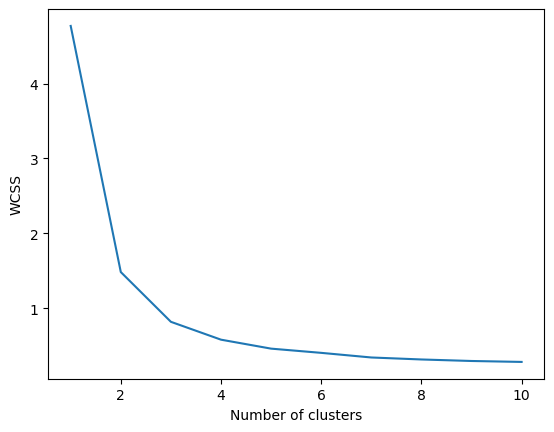

In [225]:
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [226]:
model = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans = model.fit_predict(x)
y_kmeans

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0,
       2, 0, 2, 2, 2, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 2, 2, 0, 1, 1, 0, 2,
       0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2,
       0, 0, 1, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0,

In [227]:
len(y_kmeans)

674

In [228]:
menu['cluster'] = y_kmeans
menu

,calories,fat,carbohydrates,fiber,protein,nutrition,caloric_intake_score,fat_intake_score,carb_intake_score,fiber_intake_score,protein_intake_score,composite_intake_score,cluster
menu_item,,,,,,,,,,,,,
Strawberry Acai Starbucks Refreshers™ Beverage,80.0,0.0,18.0,1.0,0.0,Nutrition(item='Strawberry Acai Starbucks Refr...,0.006275,0.000000,0.008639,0.005698,0.000000,0.004494,1
Very Berry Hibiscus Starbucks Refreshers™ Beverage,60.0,0.0,14.0,1.0,0.0,Nutrition(item='Very Berry Hibiscus Starbucks ...,0.004706,0.000000,0.006719,0.005698,0.000000,0.003561,1
Evolution Fresh™ Organic Ginger Limeade,110.0,0.0,28.0,0.0,0.0,Nutrition(item='Evolution Fresh™ Organic Ginge...,0.008627,0.000000,0.013439,0.000000,0.000000,0.005707,1
Iced Espresso Classics - Caffe Mocha,140.0,2.5,23.0,0.0,5.0,Nutrition(item='Iced Espresso Classics - Caffe...,0.010980,0.015152,0.011039,0.000000,0.008210,0.011007,1
Iced Espresso Classics - Caramel Macchiato,130.0,2.5,21.0,0.0,5.0,Nutrition(item='Iced Espresso Classics - Caram...,0.010196,0.015152,0.010079,0.000000,0.008210,0.010540,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Crispy Bell Peppers,80.0,6.0,6.0,0.0,1.0,"Nutrition(item='Crispy Bell Peppers', calories...",0.006275,0.036364,0.002880,0.000000,0.001642,0.013763,1
Harvest Nut Granola,70.0,2.0,10.0,0.0,1.0,"Nutrition(item='Harvest Nut Granola', calories...",0.005490,0.012121,0.004800,0.000000,0.001642,0.006600,1
Seasoned Tortilla Strips,70.0,4.0,8.0,1.0,1.0,"Nutrition(item='Seasoned Tortilla Strips', cal...",0.005490,0.024242,0.003840,0.005698,0.001642,0.010614,1


In [229]:
menu['cluster'].unique()

array([1, 0, 2], dtype=int32)

In [230]:
food_cluster_index = ["Food Cluster 0", "Food Cluster 1", "Food Cluster 2"]

### KMeans Model Visualization

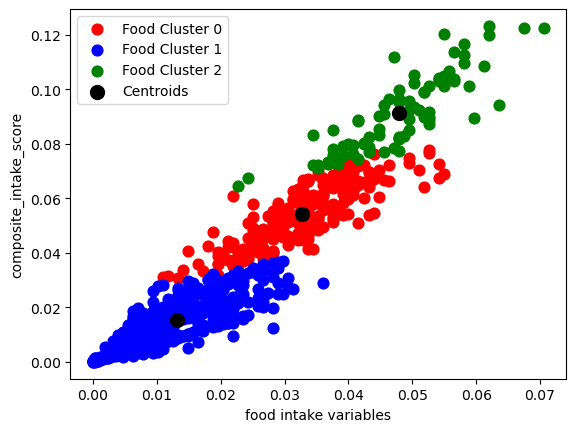

In [231]:
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 5], s=60, c='red', label=food_cluster_index[0])
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 5], s=60, c='blue', label=food_cluster_index[1])
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 5], s=60, c='green', label=food_cluster_index[2])
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 5], s = 100, c='black', label='Centroids')
plt.xlabel('food intake variables')
plt.ylabel('composite_intake_score')
plt.legend()
plt.show()

In [232]:
menu.drop(columns=["nutrition"]).groupby("cluster").median()

,calories,fat,carbohydrates,fiber,protein,caloric_intake_score,fat_intake_score,carb_intake_score,fiber_intake_score,protein_intake_score,composite_intake_score
cluster,,,,,,,,,,,
0,420.0,20.0,43.0,2.0,15.0,0.032941,0.121212,0.020638,0.011396,0.024631,0.054090
1,160.0,2.5,30.0,0.0,4.0,0.012549,0.015152,0.014399,0.000000,0.006568,0.014305
2,610.0,35.5,46.0,3.0,27.0,0.047843,0.215152,0.022078,0.017094,0.044335,0.089597


In [233]:
menu.drop(columns=["nutrition"]).groupby("cluster").count()

,calories,fat,carbohydrates,fiber,protein,caloric_intake_score,fat_intake_score,carb_intake_score,fiber_intake_score,protein_intake_score,composite_intake_score
cluster,,,,,,,,,,,
0,235,235,235,235,235,235,235,235,235,235,235
1,357,357,357,357,357,357,357,357,357,357,357
2,82,82,82,82,82,82,82,82,82,82,82


In [188]:
menu[menu["cluster"] == 2].to_csv("/tmp/cluster_2.csv")